# Numerical results for the XXZ model Gibbs state

This notebook reproduces the numerical results of the paper ["On the Sample Complexity of Quantum Boltzmann Machine Learning"](http://arxiv.org/abs/2306.14969). 

The XXZ model Hamiltonian in 1D is

$$
\mathcal{H}_{\mathrm{XXZ}}=\sum_{i=1}^{n-1} J\left(\sigma_i^x \sigma_{i+1}^x+\sigma_i^y \sigma_{i+1}^y\right)+\Delta \sigma_i^z \sigma_{i+1}^z+\sum_{i=1}^n h_z \sigma_i^z
$$

and the target state is

$$
\eta=\frac{e^{\mathcal{H}_{\mathrm{XXZ}}}}{Z}
$$

We choose the parameters

* $J=-0.5$
* $\Delta=-0.7$
* $h_z=-0.8$

In [11]:
J = -0.5
Delta = -0.7
hz = -0.8

## Define the parameters of the model: QBM

Here we select the number of qubits of the Gibbs state, the model Hamiltonian to use in the definition of the QBM, and the training hyperparameters. We do not add noise to the training.

In [1]:
import numpy as np

##########
# CONFIG #
##########

rng = np.random.default_rng(seed=1)

n_qubits = 4
model_label = 6 # 6: Geometrically local 1D chain
depolarizing_noise = 0.0 # if noisy expectation values
learning_rate = 0.2
epochs = 1000
eps = 1e-6
compute_qre = True



The model Hamiltonian is defined as a list of operators $H = \sum_{i=0}^m \theta_i H_i $

In [5]:
from qbm_quimb import hamiltonians
# A list of operators in the model Hamiltonian
model_ham_ops, model_ham_names = hamiltonians.hamiltonian_operators(n_qubits, model_label, return_names=True)

In [7]:
# this is the list of operator names
model_ham_names

['X_0_1',
 'X_1_2',
 'X_2_3',
 'X_0',
 'X_1',
 'X_2',
 'X_3',
 'Y_0_1',
 'Y_1_2',
 'Y_2_3',
 'Y_0',
 'Y_1',
 'Y_2',
 'Y_3',
 'Z_0_1',
 'Z_1_2',
 'Z_2_3',
 'Z_0',
 'Z_1',
 'Z_2',
 'Z_3']

We have `m` terms in the Hamiltonian

In [8]:
m = len(model_ham_names)

In [16]:
print(m)

21


Each operator is of shape $2^n \times 2^n$

In [10]:
print(model_ham_ops[0].shape)

(16, 16)


## Define the data

Here we work with _quantum_ data in the form of the Gibbs state of a target Hamiltonian at a fixed inverse temperature $\beta$.
The target Hamiltonian is a subset of the model Hamiltonian.


In [39]:
from qbm_quimb import data

########
# DATA #
########

# We use the label 6 to generate the terms in the target hamiltonian
# but we fix them using J, Delta, and hz
target_label = 6
target_params = np.array(3 * [J] + 4 * [0] + 3 * [J] + 4 * [0] + 3 * [Delta] + 4 * [hz])
target_beta = -1.0  # use -1 to match with the definition of the thermal state

In [40]:
target_params.shape

(21,)

In [41]:
# generate expectation values: quantum data
target_expects, target_state = data.generate_data(
    n_qubits,
    target_label,
    target_params,
    target_beta,
    model_ham_ops,
    depolarizing_noise,
)

The expectation values of the model Hamiltonian operators are computed with respect to the target Gibbs state.

In [42]:
target_expects  # expectation values w.r.t. target density matrix

[-0.4656640001798008,
 -0.4473469096987973,
 -0.46566400017980125,
 4.3845086613330065e-17,
 6.914681537656912e-17,
 -7.962046540739132e-17,
 5.21593229966328e-18,
 -0.4656640001798008,
 -0.4473469096987973,
 -0.46566400017980125,
 2.7733391199176196e-32j,
 3.4666738998970245e-33j,
 -3.851859888774472e-33j,
 4.7955655615242173e-32j,
 -0.4086864138659327,
 -0.4919460461791575,
 -0.40868641386593313,
 -0.37920165144017504,
 -0.11550306008696522,
 -0.11550306008696494,
 -0.37920165144017476]

Text(0, 0.5, 'Expectation values')

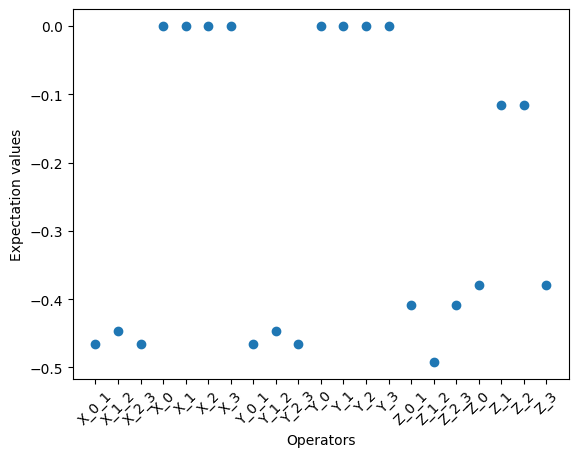

In [43]:
import matplotlib.pyplot as plt

plt.plot(np.asarray(target_expects).real,"o")
plt.xticks(np.arange(len(model_ham_names)), model_ham_names, rotation=45)
plt.xlabel("Operators")
plt.ylabel("Expectation values")

## Start the training by minimizing the relative entropy

We initialize the parameters of the model QBM and then train with stochastic gradient descent (SGD)

In [44]:
from qbm_quimb.training import QBM, train_qbm


#############
# QBM Model #
#############

initial_params = rng.normal(size=len(model_ham_ops))
qbm_state = QBM(model_ham_ops, initial_params)
print(f"Initial parameters: {qbm_state.get_coeffs()}")
print(f"Target parameters: {target_params}")
print(f"Target beta: {target_beta}")




Initial parameters: [-0.27560291  1.29406381  1.00672432 -2.71116248 -1.88901325 -0.17477209
 -0.42219041  0.213643    0.21732193  2.11783876 -1.11202076 -0.37760501
  2.04277161  0.646703    0.66306337 -0.51400637 -1.64807517  0.16746474
  0.10901409 -1.22735205 -0.68322666]
Target parameters: [-0.5 -0.5 -0.5  0.   0.   0.   0.  -0.5 -0.5 -0.5  0.   0.   0.   0.
 -0.7 -0.7 -0.7 -0.8 -0.8 -0.8 -0.8]
Target beta: -1.0


In [45]:
################
# QBM Taininig #
################

target_eta = None
if compute_qre:
    target_eta = target_state

qbm_state, max_grads_hist, qre_hist = train_qbm(
    qbm=qbm_state,
    target_expects=target_expects,
    learning_rate=learning_rate,
    epochs=epochs,
    eps=eps,
    compute_qre=compute_qre,
    target_eta=target_eta,
)

print(f"Trained parameters: {qbm_state.get_coeffs()}")
print(f"Max. gradients: {max_grads_hist[-1]}")
if compute_qre:
    print(f"Initial relative entropy: {qre_hist[0]}")
    print(f"Trained relative entropy: {qre_hist[-1]}")


Trained parameters: [-5.00000026e-01+0.00000000e+00j -5.00001600e-01+0.00000000e+00j
 -4.99999521e-01+0.00000000e+00j  1.39070516e-16+0.00000000e+00j
  1.18458423e-16+0.00000000e+00j -1.37909346e-16+0.00000000e+00j
 -1.02328919e-16+0.00000000e+00j -5.00000026e-01+0.00000000e+00j
 -5.00001600e-01+0.00000000e+00j -4.99999521e-01+0.00000000e+00j
  4.59463430e-20+3.88159625e-30j  5.47211938e-20+5.13606998e-31j
 -2.95375700e-20-6.04973114e-31j -3.92535760e-20+6.93606336e-30j
 -7.00003717e-01+0.00000000e+00j -7.00000741e-01+0.00000000e+00j
 -7.00011181e-01+0.00000000e+00j -8.00003129e-01+0.00000000e+00j
 -8.00005278e-01+0.00000000e+00j -8.00012205e-01+0.00000000e+00j
 -8.00009630e-01+0.00000000e+00j]
Max. gradients: 9.8562101931432e-07
Initial relative entropy: 10.548762983147116
Trained relative entropy: 0.045794063071167734


The relative entropy after training is close to zero, and this is reproducing the left side of panel (a) in Figure 2 of the paper.

## Plot training history

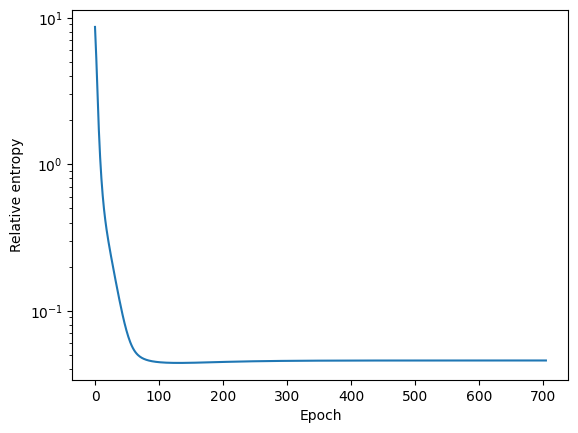

In [46]:
if compute_qre:
    plt.plot(qre_hist[1:], "-")
    plt.xlabel("Epoch")
    plt.ylabel("Relative entropy")
    plt.yscale('log')
    plt.show()


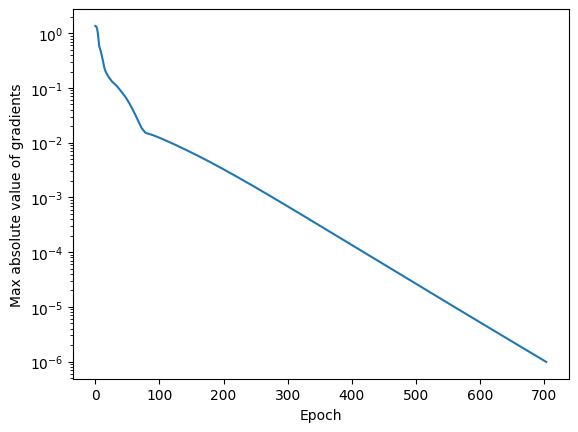

In [47]:
plt.plot(max_grads_hist[1:], "-")
plt.xlabel("Epoch")
plt.ylabel("Max absolute value of gradients")
plt.yscale('log')
plt.show()

## Compare the parameters

In [48]:
# target parameters
print(target_params)

[-0.5 -0.5 -0.5  0.   0.   0.   0.  -0.5 -0.5 -0.5  0.   0.   0.   0.
 -0.7 -0.7 -0.7 -0.8 -0.8 -0.8 -0.8]


In [49]:
# model parameters
print(qbm_state.get_coeffs())

[-5.00000026e-01+0.00000000e+00j -5.00001600e-01+0.00000000e+00j
 -4.99999521e-01+0.00000000e+00j  1.39070516e-16+0.00000000e+00j
  1.18458423e-16+0.00000000e+00j -1.37909346e-16+0.00000000e+00j
 -1.02328919e-16+0.00000000e+00j -5.00000026e-01+0.00000000e+00j
 -5.00001600e-01+0.00000000e+00j -4.99999521e-01+0.00000000e+00j
  4.59463430e-20+3.88159625e-30j  5.47211938e-20+5.13606998e-31j
 -2.95375700e-20-6.04973114e-31j -3.92535760e-20+6.93606336e-30j
 -7.00003717e-01+0.00000000e+00j -7.00000741e-01+0.00000000e+00j
 -7.00011181e-01+0.00000000e+00j -8.00003129e-01+0.00000000e+00j
 -8.00005278e-01+0.00000000e+00j -8.00012205e-01+0.00000000e+00j
 -8.00009630e-01+0.00000000e+00j]


Text(0, 0.5, 'Paramters -> |target - model|')

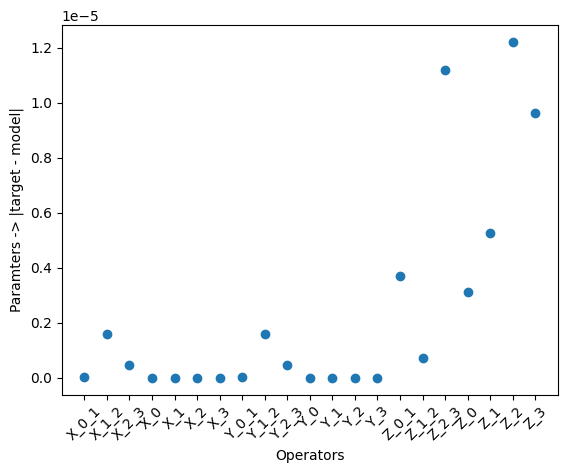

In [50]:
param_diff = np.fabs(target_params.real - qbm_state.get_coeffs().real)
plt.plot(param_diff, "o")
plt.xticks(np.arange(len(model_ham_names)), model_ham_names, rotation=45)
plt.xlabel("Operators")
plt.ylabel("Paramters -> |target - model|")

## Check fidelity with the Gibbs state

In [51]:
target_eta

[[ 4.570858e-05+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j
   0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j
   0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j]
 [ 0.000000e+00+0.j  1.870587e-03+0.j -2.887053e-03+0.j  0.000000e+00+0.j  1.560978e-03+0.j  0.000000e+00+0.j
   0.000000e+00+0.j  0.000000e+00+0.j -3.790343e-04+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j
   0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j]
 [ 0.000000e+00+0.j -2.887053e-03+0.j  7.473439e-03+0.j  0.000000e+00+0.j -5.451457e-03+0.j  0.000000e+00+0.j
   0.000000e+00+0.j  0.000000e+00+0.j  1.560978e-03+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j
   0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j]
 [ 0.000000e+00+0.j  0.000000e+00+0.j  0.000000e+00+0.j  1.476248e-02+0.j  0.000000e+00+0.j -4.224198e-02+0.j
   1.

In [52]:
qbm_state.get_density_matrix()

[[ 4.570582e-05+0.000000e+00j  4.519253e-20-7.986915e-24j -2.095879e-19+5.813225e-23j  3.683570e-16+5.650915e-39j
   1.896700e-19-6.878560e-23j -3.527679e-15-7.972758e-38j  3.925715e-15-2.401796e-38j -2.373838e-31+1.370318e-34j
  -2.559992e-20+1.242843e-23j  1.916205e-15+2.114485e-38j -3.527692e-15+7.374946e-39j  1.050431e-31-7.401328e-35j
   3.683640e-16-3.581632e-38j -2.884663e-31+5.943679e-35j  4.511188e-31-1.044820e-34j  6.497450e-28+9.663178e-47j]
 [ 4.519253e-20+7.986915e-24j  1.870553e-03+7.595502e-24j -2.887008e-03+2.726026e-22j  6.973363e-18+4.296375e-21j
   1.560944e-03-1.553632e-21j -2.636336e-17-1.315868e-20j  1.403932e-17+6.457986e-21j  4.800239e-15-5.804755e-21j
  -3.790243e-04+4.850426e-22j  1.928677e-17+2.952955e-21j -1.842741e-17+1.030573e-21j  1.532144e-16+9.250172e-21j
   3.454453e-18-7.710795e-22j -9.464076e-15+2.529942e-22j  4.837871e-15-1.278659e-21j  1.530489e-23-2.319672e-27j]
 [-2.095879e-19-5.813225e-23j -2.887008e-03-2.363313e-22j  7.473337e-03+2.143624e-22j 

In [53]:
from quimb import fidelity

fidelity(target_eta, qbm_state.get_density_matrix())

0.9999999999963443

Since the QBM model contains the operators of the Hamiltonian used to create the target quantum Gibbs state as a subset, the training is able to find the parameters correctly. Therefore the fidelity between the target state and the QBM state after training is 1.

## Pretraining

In Fig.2 of the paper, the authors compare different pre-training strategies. Pretraining can be implemented simply as 2 consecutive rounds of training, where the first one only targets a subset of the parameters.

### Select the full QBM model

We will use a fully connected QBM model defined in equation (16) of the paper as:

$$
\mathcal{H}_\theta=\sum_{k=x, y, z} \sum_{i, j>i} \lambda_{i j}^k \sigma_i^k \sigma_j^k+\sum_i^n \gamma_i^k \sigma_i^k
$$


In [54]:
model_label = 8  # 8: Fully connected
model_ham_ops, model_ham_names = hamiltonians.hamiltonian_operators(
    n_qubits, model_label, return_names=True
)

In [55]:
m = len(model_ham_names)
print(f"We have {m} terms in the Hamiltonian")

We have 30 terms in the Hamiltonian


### Select pretraining strategy

We will pretrain by using a geometrically local Hamiltonian, whose operators are a subset of the full model

$$
\mathcal{H}_\theta^{\mathrm{GL}}=\sum_{k=x, y, z} \sum_{\langle i, j\rangle} \lambda_{i j}^k \sigma_i^k \sigma_j^k+\sum_i^n \gamma_i^k \sigma_i^k
$$

In [56]:
pre_model_label = 7  # 7: Geometrically local (2D lattice)
pre_model_ham_ops, pre_model_ham_names = hamiltonians.hamiltonian_operators(
    n_qubits, pre_model_label, return_names=True
)

In [59]:
m = len(pre_model_ham_names)
print(f"We have {m} terms in the pretraining Hamiltonian")

We have 24 terms in the pretraining Hamiltonian


### Generate data for pretraining and do pretraining

In [75]:
# generate expectation values: quantum data
target_expects, target_state = data.generate_data(
    n_qubits,
    target_label,
    target_params,
    target_beta,
    pre_model_ham_ops,
    depolarizing_noise,
)

The pretraining QBM state we use is

In [76]:
initial_params = rng.normal(size=len(pre_model_ham_ops))
pre_qbm_state = QBM(pre_model_ham_ops, initial_params)
print(f"Initial parameters: {pre_qbm_state.get_coeffs()}")
print(f"Target parameters: {target_params}")
print(f"Target beta: {target_beta}")

Initial parameters: [-8.10814583e-01  7.52243827e-01  2.53446516e-01  8.95883071e-01
 -3.45215710e-01 -1.48181827e+00 -1.10010765e-01 -4.45828153e-01
  7.75323822e-01  1.93632848e-01 -1.63084923e+00 -1.19516308e+00
  8.83789037e-01  6.79765017e-01 -6.40243366e-01 -1.04879657e-03
  4.45573554e-01  4.68404336e-01  8.76242196e-01  2.56485627e-01
 -9.48283390e-02 -2.58848065e-01  1.05574280e+00 -2.25085428e+00]
Target parameters: [-0.5 -0.5 -0.5  0.   0.   0.   0.  -0.5 -0.5 -0.5  0.   0.   0.   0.
 -0.7 -0.7 -0.7 -0.8 -0.8 -0.8 -0.8]
Target beta: -1.0


In [77]:
target_eta = None
if compute_qre:
    target_eta = target_state

pre_qbm_state, max_grads_hist, qre_hist = train_qbm(
    qbm=pre_qbm_state,
    target_expects=target_expects,
    learning_rate=learning_rate,
    epochs=epochs,
    eps=eps,
    compute_qre=compute_qre,
    target_eta=target_eta,
)

print(f"Trained parameters: {pre_qbm_state.get_coeffs()}")
print(f"Max. gradients: {max_grads_hist[-1]}")
if compute_qre:
    print(f"Initial relative entropy: {qre_hist[0]}")
    print(f"Trained relative entropy: {qre_hist[-1]}")

Trained parameters: [-4.17862429e-01+0.00000000e+00j  2.41887006e-01+0.00000000e+00j
  2.41887424e-01+0.00000000e+00j -4.17862135e-01+0.00000000e+00j
  1.21627905e-16+0.00000000e+00j  1.49677930e-16+0.00000000e+00j
 -9.98886686e-17+0.00000000e+00j -7.07296023e-17+0.00000000e+00j
 -4.17862429e-01+0.00000000e+00j  2.41887006e-01+0.00000000e+00j
  2.41887424e-01+0.00000000e+00j -4.17862135e-01+0.00000000e+00j
 -1.28638650e-17+2.66240556e-30j  1.01817695e-17+3.32800694e-31j
 -4.54926588e-18-3.69778549e-31j -3.11582305e-19+4.60374294e-30j
 -6.00291272e-01+0.00000000e+00j  2.60564317e-01+0.00000000e+00j
  2.60565061e-01+0.00000000e+00j -6.00296141e-01+0.00000000e+00j
 -7.47485462e-01+0.00000000e+00j -4.23410028e-01+0.00000000e+00j
 -4.23415148e-01+0.00000000e+00j -7.47490210e-01+0.00000000e+00j]
Max. gradients: 9.933717574628353e-07
Initial relative entropy: 5.378765065724189
Trained relative entropy: 0.37111624954291145


In [78]:
pretraining_qre = qre_hist[-1]

### Generate data for full training and do full training

In [79]:
# generate expectation values: quantum data
target_expects, target_state = data.generate_data(
    n_qubits,
    target_label,
    target_params,
    target_beta,
    model_ham_ops,
    depolarizing_noise,
)

We need to initialize the parameters based on our pretraining strategy

In [80]:
operator_map = {
    "X_0_1": "X_0-0_0-1",
    "X_0_3": "X_0-0_1-0",
    "X_1_2": "X_0-1_1-1",
    "X_2_3": "X_1-0_1-1",
    "X_0": "X_0",
    "X_1": "X_1",
    "X_2": "X_2",
    "X_3": "X_3",
    "Y_0_1": "Y_0-0_0-1",
    "Y_0_3": "Y_0-0_1-0",
    "Y_1_2": "Y_0-1_1-1",
    "Y_2_3": "Y_1-0_1-1",
    "Y_0": "Y_0",
    "Y_1": "Y_1",
    "Y_2": "Y_2",
    "Y_3": "Y_3",
    "Z_0_1": "Z_0-0_0-1",
    "Z_0_3": "Z_0-0_1-0",
    "Z_1_2": "Z_0-1_1-1",
    "Z_2_3": "Z_1-0_1-1",
    "Z_0":   "Z_0",
    "Z_1":   "Z_1",
    "Z_2":   "Z_2",
    "Z_3":   "Z_3",
}

In [81]:
pre_op_map = {k: v for k, v in zip(pre_model_ham_names, pre_qbm_state.get_coeffs(),)}
pre_op_map

{'X_0-0_0-1': (-0.4178624286438567+0j),
 'X_0-0_1-0': (0.24188700616159095+0j),
 'X_0-1_1-1': (0.24188742409107108+0j),
 'X_1-0_1-1': (-0.417862135162397+0j),
 'X_0': (1.2162790526676357e-16+0j),
 'X_1': (1.4967792966126619e-16+0j),
 'X_2': (-9.988866855167014e-17+0j),
 'X_3': (-7.072960231885689e-17+0j),
 'Y_0-0_0-1': (-0.4178624286438564+0j),
 'Y_0-0_1-0': (0.24188700616159092+0j),
 'Y_0-1_1-1': (0.24188742409107103+0j),
 'Y_1-0_1-1': (-0.4178621351623975+0j),
 'Y_0': (-1.2863864981099544e-17+2.6624055551208945e-30j),
 'Y_1': (1.0181769524937324e-17+3.328006943901118e-31j),
 'Y_2': (-4.5492658825577755e-18-3.697785493223493e-31j),
 'Y_3': (-3.1158230544471792e-19+4.6037429390632086e-30j),
 'Z_0-0_0-1': (-0.6002912720001596+0j),
 'Z_0-0_1-0': (0.2605643173897259+0j),
 'Z_0-1_1-1': (0.26056506144579467+0j),
 'Z_1-0_1-1': (-0.6002961405083312+0j),
 'Z_0': (-0.7474854620019284+0j),
 'Z_1': (-0.42341002824384955+0j),
 'Z_2': (-0.4234151479744083+0j),
 'Z_3': (-0.747490209582286+0j)}

In [85]:
# initialize parameters from pre-training
initial_params = []
for op in model_ham_names:
    try:
        if operator_map[op] in pre_model_ham_names:
            initial_params.append(pre_op_map[operator_map[op]])
        else:
            initial_params.append(0.0)
    except KeyError:
        initial_params.append(0)
print(initial_params)

[(-0.4178624286438567+0j), 0, (0.24188700616159095+0j), (0.24188742409107108+0j), 0, (-0.417862135162397+0j), (1.2162790526676357e-16+0j), (1.4967792966126619e-16+0j), (-9.988866855167014e-17+0j), (-7.072960231885689e-17+0j), (-0.4178624286438564+0j), 0, (0.24188700616159092+0j), (0.24188742409107103+0j), 0, (-0.4178621351623975+0j), (-1.2863864981099544e-17+2.6624055551208945e-30j), (1.0181769524937324e-17+3.328006943901118e-31j), (-4.5492658825577755e-18-3.697785493223493e-31j), (-3.1158230544471792e-19+4.6037429390632086e-30j), (-0.6002912720001596+0j), 0, (0.2605643173897259+0j), (0.26056506144579467+0j), 0, (-0.6002961405083312+0j), (-0.7474854620019284+0j), (-0.42341002824384955+0j), (-0.4234151479744083+0j), (-0.747490209582286+0j)]


In [86]:
qbm_state = QBM(model_ham_ops, initial_params)
print(f"Initial parameters: {qbm_state.get_coeffs()}")
print(f"Target parameters: {target_params}")
print(f"Target beta: {target_beta}")

Initial parameters: [(-0.4178624286438567+0j), 0, (0.24188700616159095+0j), (0.24188742409107108+0j), 0, (-0.417862135162397+0j), (1.2162790526676357e-16+0j), (1.4967792966126619e-16+0j), (-9.988866855167014e-17+0j), (-7.072960231885689e-17+0j), (-0.4178624286438564+0j), 0, (0.24188700616159092+0j), (0.24188742409107103+0j), 0, (-0.4178621351623975+0j), (-1.2863864981099544e-17+2.6624055551208945e-30j), (1.0181769524937324e-17+3.328006943901118e-31j), (-4.5492658825577755e-18-3.697785493223493e-31j), (-3.1158230544471792e-19+4.6037429390632086e-30j), (-0.6002912720001596+0j), 0, (0.2605643173897259+0j), (0.26056506144579467+0j), 0, (-0.6002961405083312+0j), (-0.7474854620019284+0j), (-0.42341002824384955+0j), (-0.4234151479744083+0j), (-0.747490209582286+0j)]
Target parameters: [-0.5 -0.5 -0.5  0.   0.   0.   0.  -0.5 -0.5 -0.5  0.   0.   0.   0.
 -0.7 -0.7 -0.7 -0.8 -0.8 -0.8 -0.8]
Target beta: -1.0


In [87]:
target_eta = None
if compute_qre:
    target_eta = target_state

qbm_state, max_grads_hist, qre_hist = train_qbm(
    qbm=qbm_state,
    target_expects=target_expects,
    learning_rate=learning_rate,
    epochs=epochs,
    eps=eps,
    compute_qre=compute_qre,
    target_eta=target_eta,
)

print(f"Trained parameters: {pre_qbm_state.get_coeffs()}")
print(f"Max. gradients: {max_grads_hist[-1]}")
if compute_qre:
    print(f"Initial relative entropy: {qre_hist[0]}")
    print(f"Trained relative entropy: {qre_hist[-1]}")

Trained parameters: [-4.17862429e-01+0.00000000e+00j  2.41887006e-01+0.00000000e+00j
  2.41887424e-01+0.00000000e+00j -4.17862135e-01+0.00000000e+00j
  1.21627905e-16+0.00000000e+00j  1.49677930e-16+0.00000000e+00j
 -9.98886686e-17+0.00000000e+00j -7.07296023e-17+0.00000000e+00j
 -4.17862429e-01+0.00000000e+00j  2.41887006e-01+0.00000000e+00j
  2.41887424e-01+0.00000000e+00j -4.17862135e-01+0.00000000e+00j
 -1.28638650e-17+2.66240556e-30j  1.01817695e-17+3.32800694e-31j
 -4.54926588e-18-3.69778549e-31j -3.11582305e-19+4.60374294e-30j
 -6.00291272e-01+0.00000000e+00j  2.60564317e-01+0.00000000e+00j
  2.60565061e-01+0.00000000e+00j -6.00296141e-01+0.00000000e+00j
 -7.47485462e-01+0.00000000e+00j -4.23410028e-01+0.00000000e+00j
 -4.23415148e-01+0.00000000e+00j -7.47490210e-01+0.00000000e+00j]
Max. gradients: 9.919792962470586e-07
Initial relative entropy: 1.0078189614397504
Trained relative entropy: 0.045795815093487846
